In [1]:
import pyspark as ps    # for the pyspark suite
import pandas as pd

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[*]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
spark

In [4]:
df = spark.read.option("inferschema", "true").csv('data/patent.tsv',
                    header=True,       # use headers or not
                    quote='"',         # char for quotes
                    sep="\t")          # char for separation  

# prints the schema
df.printSchema()

# some functions are still valid
#print("line count: {}\n".format(df.count()))
#df = df.limit(100)
# show the table in a oh-so-nice format
#df.show()

root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- number: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- abstract: string (nullable = true)
 |-- title: string (nullable = true)
 |-- kind: string (nullable = true)
 |-- num_claims: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- withdrawn: string (nullable = true)



In [5]:
df = df.drop('country')
df = df.drop('filename')
df = df.drop('number')
df.show()

+--------+-------+-------------------+--------------------+--------------------+----+----------+---------+
|      id|   type|               date|            abstract|               title|kind|num_claims|withdrawn|
+--------+-------+-------------------+--------------------+--------------------+----+----------+---------+
|10000000|utility|2018-06-19 00:00:00|A frequency modul...|Coherent LADAR us...|  B2|        20|     NULL|
|10000001|utility|2018-06-19 00:00:00|The injection mol...|Injection molding...|  B2|        12|     NULL|
|10000002|utility|2018-06-19 00:00:00|The present inven...|Method for manufa...|  B2|         9|     NULL|
|10000003|utility|2018-06-19 00:00:00|The invention rel...|Method for produc...|  B2|        18|     NULL|
|10000004|utility|2018-06-19 00:00:00|The present inven...|Process of obtain...|  B2|         6|     NULL|
|10000005|utility|2018-06-19 00:00:00|A vacuum forming ...|Article vacuum fo...|  B2|         4|     NULL|
|10000006|utility|2018-06-19 00:00:00

In [15]:
from pyspark.sql.functions import year
from pyspark.sql.functions import col
year_group = df.groupby(year("date").alias("year")).count().sort(col("year").asc())
year_group.show()

+----+------+
|year| count|
+----+------+
|1976| 70941|
|1977| 69820|
|1978| 70586|
|1979| 52484|
|1980| 66212|
|1981| 71112|
|1982| 63292|
|1983| 62019|
|1984| 72689|
|1985| 77276|
|1986| 77050|
|1987| 89591|
|1988| 84449|
|1989|102719|
|1990| 99275|
|1991|106891|
|1992|107540|
|1993|109933|
|1994|113723|
|1995|113954|
+----+------+
only showing top 20 rows



In [19]:
year_group.count()

44

In [22]:
 pd_year_group = year_group.toPandas()

In [23]:
pd_year_group.head()

,year,count
0,1976,70941
1,1977,69820
2,1978,70586
3,1979,52484
4,1980,66212


In [24]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

<BarContainer object of 44 artists>

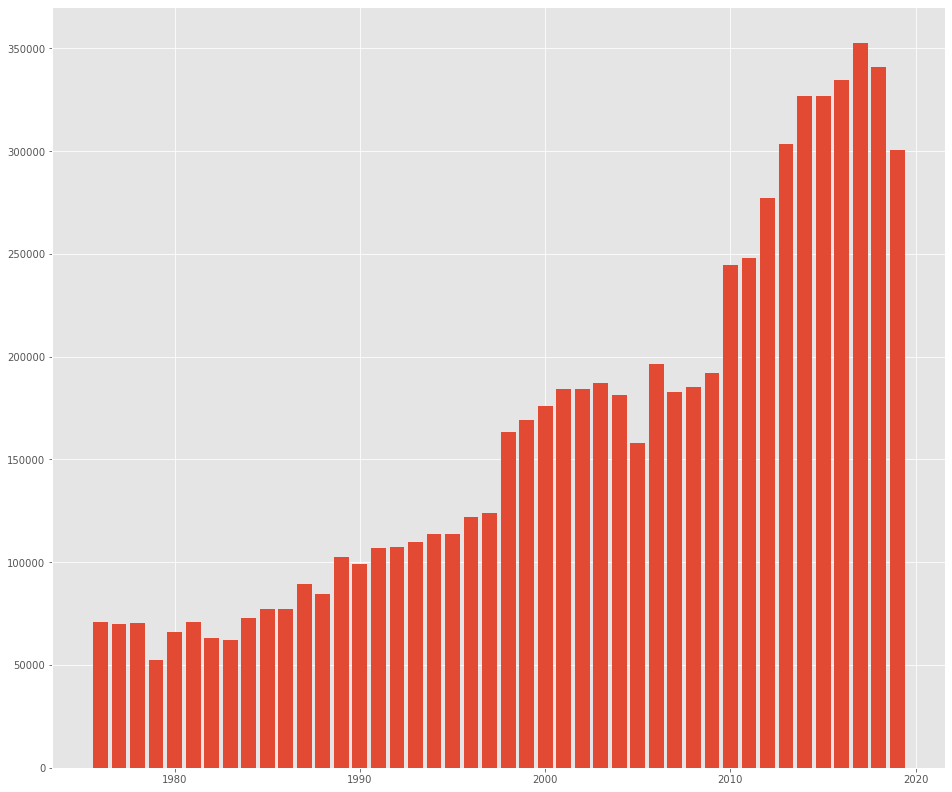

In [35]:

fig, ax = plt.subplots(figsize=(16,14))
ax.bar(pd_year_group['year'],pd_year_group['count'])

In [12]:
df_cpc = spark.read.option("inferschema", "true").csv('data/cpc_current.tsv',
                    header=True,       # use headers or not
                    quote='"',         # char for quotes
                    sep="\t")          # char for separation  

# prints the schema
df_cpc.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- patent_id: integer (nullable = true)
 |-- section_id: string (nullable = true)
 |-- subsection_id: string (nullable = true)
 |-- group_id: string (nullable = true)
 |-- subgroup_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sequence: integer (nullable = true)



In [13]:
df_with_groups = df.join(df_cpc, df.id == df_cpc.patent_id).drop('id')

In [65]:

groupID_year_group = df_with_groups.withColumn("group_id_first", df_with_groups.group_id.substr(0,1)).groupby([year("date").alias("year"),'group_id_first']).count().sort([col("year").asc(),'group_id_first'])
groupID_year_group.show()

+----+--------------+-----+
|year|group_id_first|count|
+----+--------------+-----+
|1976|             A|21546|
|1976|             B|52299|
|1976|             C|69699|
|1976|             D| 5281|
|1976|             E| 7546|
|1976|             F|22982|
|1976|             G|22769|
|1976|             H|23597|
|1976|             Y|33349|
|1977|             A|20586|
|1977|             B|45844|
|1977|             C|59459|
|1977|             D| 4226|
|1977|             E| 7003|
|1977|             F|20927|
|1977|             G|21260|
|1977|             H|23601|
|1977|             Y|27411|
|1978|             A|20250|
|1978|             B|47324|
+----+--------------+-----+
only showing top 20 rows



In [66]:
pd_year_groupID_group = groupID_year_group.toPandas()

In [67]:
pd_year_groupID_group.head(50)

,year,group_id_first,count
0,1976,A,21546
1,1976,B,52299
2,1976,C,69699
3,1976,D,5281
4,1976,E,7546
5,1976,F,22982
6,1976,G,22769
7,1976,H,23597
8,1976,Y,33349
9,1977,A,20586


In [75]:
grouped_id_pd_sum = pd_year_groupID_group.groupby('group_id_first').sum()

In [76]:
grouped_id_pd_sum = grouped_pd.reset_index()

In [77]:
grouped_id_pd_sum.head()

,index,group_id_first,year,count
0,0,A,87890,5136729
1,1,B,87890,5325329
2,2,C,87890,5261426
3,3,D,87890,258880
4,4,E,87890,630780


<BarContainer object of 9 artists>

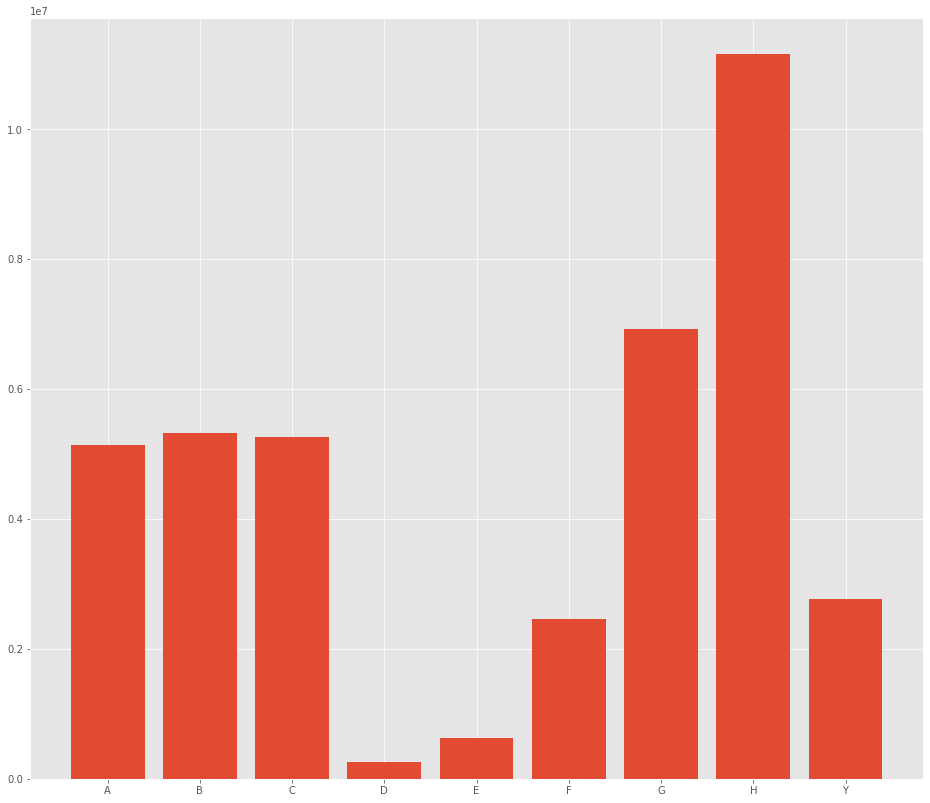

In [74]:
fig, ax = plt.subplots(figsize=(16,14))
ax.bar(grouped_id_pd_sum['group_id_first'], grouped_id_pd_sum['count'])

In [82]:
#grouped_id_pd = pd_year_groupID_group.sort('group_id_first')

AttributeError: 'DataFrame' object has no attribute 'sort'

In [86]:
pd_year_groupID_group.head(20)

,year,group_id_first,count
0,1976,A,21546
1,1976,B,52299
2,1976,C,69699
3,1976,D,5281
4,1976,E,7546
5,1976,F,22982
6,1976,G,22769
7,1976,H,23597
8,1976,Y,33349
9,1977,A,20586


In [ ]:
df = pd.DataFrame(np.random.randn(1000, 4), index=pd.date_range('1/1/2000', periods=1000), columns=list('ABCD'))
df = df.cumsum()

df.plot(linestyle='-', markevery=100, marker='o', markerfacecolor='black')

plt.show()

In [91]:
pd_year_vs_group = pd_year_groupID_group.pivot(index=pd_year_groupID_group['year'], columns='group_id_first')['count']

In [99]:
pd_year_vs_group[:-1]

group_id_first,A,B,C,D,E,F,G,H,Y
year,,,,,,,,,
1976,21546,52299,69699,5281,7546,22982,22769,23597,33349
1977,20586,45844,59459,4226,7003,20927,21260,23601,27411
1978,20250,47324,71407,4317,8207,21918,21968,22353,30628
1979,16648,34705,49912,2842,4944,16524,17067,16709,20618
1980,22330,42576,58125,3907,6571,22029,21222,20787,27378
1981,22634,48300,62611,3974,7282,23259,23378,22605,31453
1982,20730,41460,52101,3311,6126,21217,21174,23296,29174
1983,19104,40090,52809,3438,6212,20929,21053,23017,30083
1984,22538,46516,56219,3882,7695,25944,25546,26403,35450


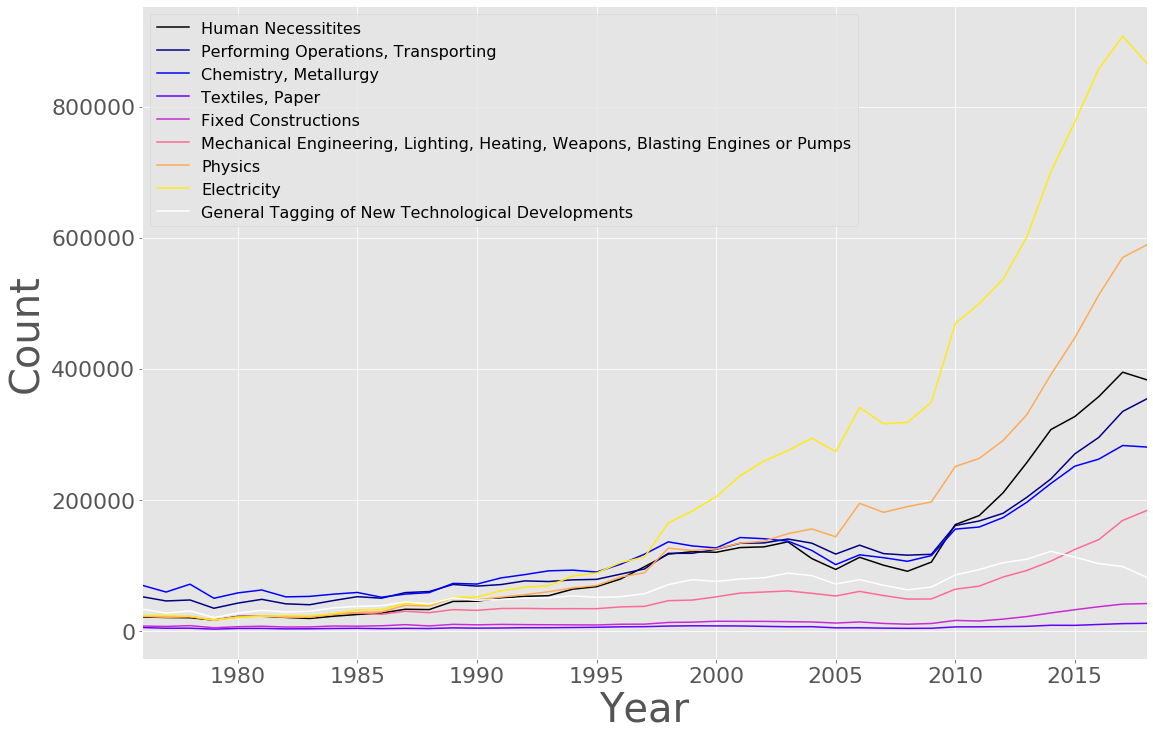

In [154]:
fig,ax = plt.subplots(figsize=(18,12))
pd_year_vs_group[:-1].plot(ax=ax,cmap=plt.get_cmap("gnuplot2"))
ax.legend(["Human Necessitites", "Performing Operations, Transporting", "Chemistry, Metallurgy","Textiles, Paper", "Fixed Constructions", "Mechanical Engineering, Lighting, Heating, Weapons, Blasting Engines or Pumps", "Physics", "Electricity", "General Tagging of New Technological Developments"]
         ,fontsize=16);
ax.set_xlabel('Year', fontsize=40)
ax.set_ylabel('Count', fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=22)
plt.savefig("count_sections_per_year.jpg")

In [140]:
df_with_groups.head()

Row(type='utility', date=datetime.datetime(1976, 1, 6, 0, 0), abstract=' A soap bar composed of a hollow shell of bar soap material defining a cavity filled by a core composed of small remaining pieces of soap bars and a congealed mass of a soap solution. The shell has an access opening through which the soap pieces and solution, in a fluent form, are applied to the cavity. ', title='Soap bar', kind='A', num_claims=4, withdrawn='0', uuid='f53eqlsu09piax34s6kg3z445', patent_id=3931035, section_id='C', subsection_id='C11', group_id='C11D', subgroup_id='C11D17/0039', category='inventional', sequence=1)

In [14]:
df_2019_A = df_with_groups.filter(df_with_groups['date']=='2019').filter(df_with_groups['section_id']=='A')

In [150]:
df_2019_A.count()

7285

In [162]:
from pyspark.sql.functions import avg, length, mean
df_2019_A.agg(mean(length(col("abstract")))).show()

+---------------------+
|avg(length(abstract))|
+---------------------+
|    628.3442690459849|
+---------------------+



In [6]:
conda install nltk

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_treebank_pos_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
from nltk.corpus import stopwords

stopwords_ = set(stopwords.words('english'))
print("--- stopwords in english: {}".format(stopwords_))

--- stopwords in english: {'above', 'wouldn', 'mustn', 'don', 'theirs', 'from', 'there', 'for', 'nor', 'yourself', 'but', "mustn't", "aren't", 'those', 'm', 'haven', 'or', 'where', 'o', 't', 'under', 'such', 'll', 'that', 'his', 'hasn', 'our', 'then', 'mightn', 'will', "wouldn't", "you'd", 'up', 'through', "doesn't", 'while', "she's", "won't", 'couldn', 'both', 'and', "shan't", 'is', 'to', 'not', 'at', 'being', 'can', 'again', 'what', 'does', 'its', 'very', 'once', 'other', 'some', 'yours', "didn't", 'having', "needn't", 'this', 'against', 'over', 'no', 'these', 'just', 'myself', "that'll", 'been', 'd', 've', 'if', 'into', 'most', 'should', 'himself', 'be', 'they', 'so', 'doing', "shouldn't", 'down', 'has', 'him', 'more', 'with', 'we', 'hadn', 'have', 'her', 'which', 'because', 'all', 'won', 'why', 'aren', 'wasn', 'i', 'do', 'your', 'how', 'here', 'hers', 're', 'out', 'itself', 'off', "you've", 'isn', "isn't", 'a', "hasn't", 'she', "you'll", "weren't", 'had', 's', 'doesn', "wasn't", 'o

In [ ]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

input_string = remove_accents(paragraph)

In [15]:
from pyspark.sql.functions import lower, col
df_2019_A.select(lower(col('abstract'))).show()

+--------------------+
|     lower(abstract)|
+--------------------+
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|the invention dis...|
|a hookah system f...|
|a hookah system f...|
|a hookah system f...|
|the present inven...|
|the present inven...|
|the present inven...|
|the present inven...|
+--------------------+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import regexp_extract, col, regexp_replace
#df_2019_A = df_2019_A.filter(col("abstract") rlike "([a-z]+)")


In [17]:
# Tokenize text
from pyspark.ml.feature import Tokenizer, StopWordsRemover
#tokenizer = Tokenizer(inputCol='abstract', outputCol='abstract_tokenized')
#df_2019_A = tokenizer.transform(df_2019_A)

In [18]:
#df_2019_A.show(1,False)

In [19]:

def clean_and_tokenize_abstract(df):
    #set abstract to lower case
    df = df.withColumn('abstract', lower(col('abstract')).alias('abstract'))
    #remove all non letters
    df = df.withColumn('abstract',regexp_replace(col('abstract'), '\W+', " "))
    # Tokenize text
    tokenizer = Tokenizer(inputCol='abstract', outputCol='abstract_tokenized')
    df = tokenizer.transform(df)
    # Remove stop words
    remover = StopWordsRemover(inputCol='abstract_tokenized', outputCol='abstract_cleaned')
    df = remover.transform(df)
    return df.select('abstract_cleaned')

In [20]:
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer

In [21]:
from pyspark.sql.functions import udf
from nltk.stem import WordNetLemmatizer
from pyspark.sql.types import ArrayType, StringType
def lem_abstract(df):
# Lem text
    lemmer = WordNetLemmatizer()
    lemmer_udf = udf(lambda tokens: [lemmer.lemmatize(token) for token in tokens], ArrayType(StringType()))
    return df.withColumn("abstract_lemmed", lemmer_udf("abstract_cleaned"))


In [22]:
df_2019_A.show(1,False)

+-------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+----+----------+---------+-------------------------+---------+----------+-------------+--------+-----------+-----------+--------+
|type   |date               |abstract                                                                                                                                                                                                                                                                                                                                                                                        |ti

In [23]:
from pyspark.sql.types.DataType import VectorUDT
from pyspark.mllib.linalg import DenseVector

ModuleNotFoundError: No module named 'pyspark.sql.types.DataType'; 'pyspark.sql.types' is not a package

In [70]:
lem_df.show(1,False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_cleaned                                                                                                                                                                                                                                                                            

In [24]:


# dense the current response variable
def to_dense(in_vec):
    return DenseVector(in_vec.toArray())

def tfidf_vectors(df):
# vectorize
    vectorizer = CountVectorizer(inputCol='abstract_lemmed', outputCol='vectorized').fit(df)
    return vectorizer.transform(df)
    
# calculate scores
    idf = IDF(inputCol="vectorized", outputCol="tfidf_features")
    idf_model = idf.fit(vectorized_df)
    idf_df = idf_model.transform(vectorized_df)
    to_dense_udf = udf(lambda x: to_dense(x), VectorUDT())

# create dense vector
    return idf_df.withColumn("tfidf_features_dense", to_dense_udf('tfidf_features'))

In [25]:
def spark_tfidf(doc):    
    hashingTF = HashingTF(inputCol="abstract_lemmed", outputCol="rawFeatures", numFeatures=20)
    featurizedData = hashingTF.transform(doc) 
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    idfModel = idf.fit(featurizedData)
    rescaledData = idfModel.transform(featurizedData)
 
    return rescaledData.select("features")

In [26]:
clean_abstract = clean_and_tokenize_abstract(df_2019_A.limit(1))
lem_df = lem_abstract(clean_abstract)


In [27]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#from pyspark.sql import SparkSessio

In [104]:
#features = spark_tfidf(lem_df)

In [105]:
#features.show()

+--------------------+
|            features|
+--------------------+
|(20,[0,1,2,4,5,7,...|
+--------------------+



In [28]:
features2 = tfidf_vectors(lem_df)

In [110]:
from pyspark.ml.linalg import Vectors

In [118]:
from pyspark.mllib.linalg import SparseVector, DenseVector
DenseVector(features2.select("vectorized").collect())

TypeError: type numpy.ndarray doesn't define __round__ method

In [109]:
#features2.show()

+--------------------+--------------------+--------------------+
|    abstract_cleaned|     abstract_lemmed|          vectorized|
+--------------------+--------------------+--------------------+
|[invention, discl...|[invention, discl...|(24,[0,1,2,3,4,5,...|
+--------------------+--------------------+--------------------+



In [ ]:
(trainingData, testData) = features2.randomSplit([0.8, 0.2],seed = 11)